## Day 13: Geometric Image Transformations

In [6]:
# boilerplate setup
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

#### Goals

* Know what kinds of transformations can be represented using linear and affine transformations.
* Review homogeneous coordinates
* Know the definition of a projective transformation (homography), and gain some geometric intuition for what it represents in 2D.

Next time:

* Know how to find a least-squares best-fit transformation for:
  * translation
  * affine
  * homography

### Context: Panorama Stitching Overview

(See slide deck: Intro to Panorama Stitching)

* [x] Detect features - Harris corners
* [x] Describe features - MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences
    * [ ] Translation
    * [ ] Affine
    * [ ] Projective
    * [ ] Robustness to outliers - RANSAC
* Warp image(s) into common coordinate system and blend
    * [ ] Inverse warping
    * [ ] Blending

#### Panorama Stitching: Example Cases

**Question:** What sort of model can describe the pixel correspondances between the left and right images?

$$ \mathbf{p}_{L} = f_{\mathrm{model}}(\mathbf{p}_R) $$


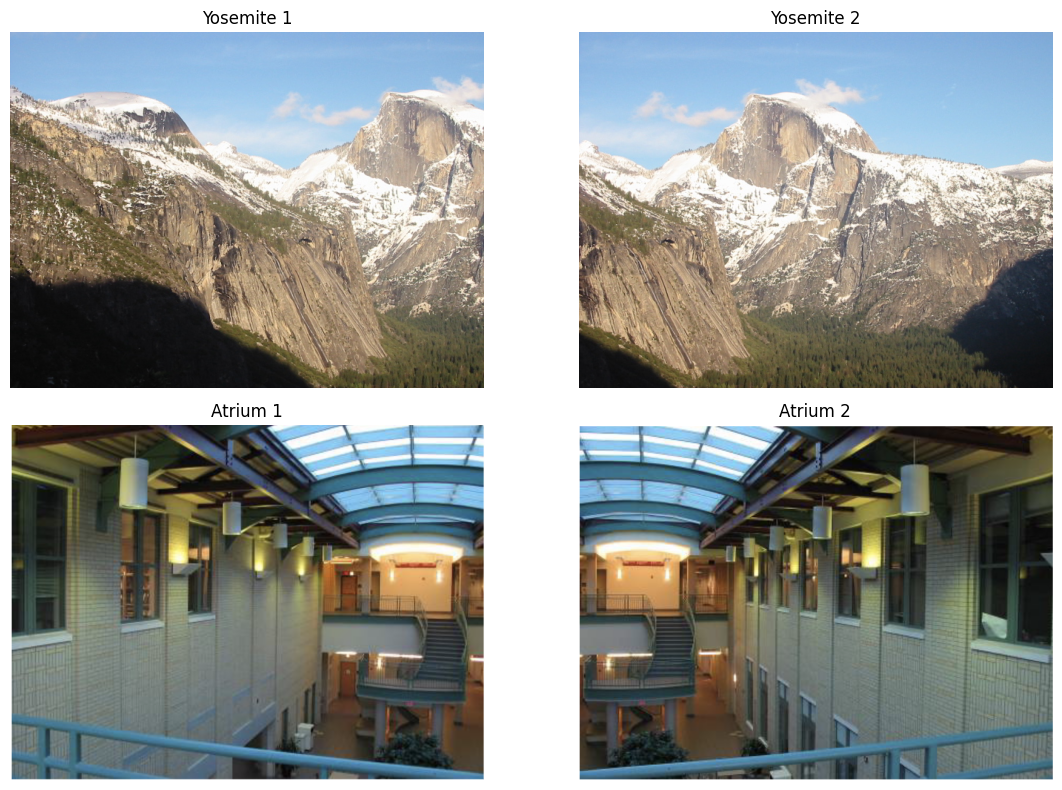

In [7]:
# Display example panorama pairs
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Load and display Yosemite pair
yos1 = cv2.imread("../data/yos1.jpg")
yos2 = cv2.imread("../data/yos2.jpg")
axes[0, 0].imshow(cv2.cvtColor(yos1, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Yosemite 1")
axes[0, 0].axis('off')
axes[0, 1].imshow(cv2.cvtColor(yos2, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Yosemite 2")
axes[0, 1].axis('off')

# Load and display Atrium pair
atrium1 = cv2.imread("../data/atrium1.png")
atrium2 = cv2.imread("../data/atrium2.png")
axes[1, 0].imshow(cv2.cvtColor(atrium1, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Atrium 1")
axes[1, 0].axis('off')
axes[1, 1].imshow(cv2.cvtColor(atrium2, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Atrium 2")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


**Question**: what geometric relationships can translations model? How about affine?

(Work out equations for various motion models on the tablet.)

Quick summary:

**Translation** (2 DOF): shift by a constant vector
$$
\mathbf{p}' = \mathbf{p} + \mathbf{t}, \quad \text{where } \mathbf{t} = \begin{bmatrix} t_x \\ t_y \end{bmatrix}
$$

**Linear** (4 DOF): multiply by a 2×2 matrix
$$
\mathbf{p}' = M\mathbf{p}, \quad \text{where } M = \begin{bmatrix} m_{11} & m_{12} \\ m_{21} & m_{22} \end{bmatrix}
$$

**Affine** (6 DOF): linear + translation

Form 1 (matrix and vector):
$$
\mathbf{p}' = M\mathbf{p} + \mathbf{t}
$$

Form 2 (homogeneous coordinates):
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = 
\begin{bmatrix} 
m_{11} & m_{12} & t_x \\ 
m_{21} & m_{22} & t_y \\ 
0 & 0 & 1 
\end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

---

### Concept Question

Consider the following geometric properties. For each type of transformation, give a list of letters corresponding to which properties are preserved (i.e., left unchanged) by that class of transformations.

**Properties:**

- A. Line straightness
- B. Line lengths
- C. Parallelism of lines
- D. Angles
- E. Locations of points
- F. Location of the origin

**Question:**

  - Which are preserved under translational transformations?
  - Which are preserved under affine transformations?

**Notes:** 

- Use [this online demo](https://iis.uibk.ac.at/public/piater/courses/demos/homography/homography.xhtml) to gain intuition and try things out as you work through these
- Affine transformations are only those where the last row remains $\begin{bmatrix}0 & 0 & 1\end{bmatrix}$. Don't change the bottom row.

---

**Claim:** Affine translations *can't* model a typical panorama sequence well beyond a certain field of view.

**Justification:** Let's talk about train tracks.

![](../data/tracks1.png)

What would you see if you changed your view angle to point straight down towards the tracks?

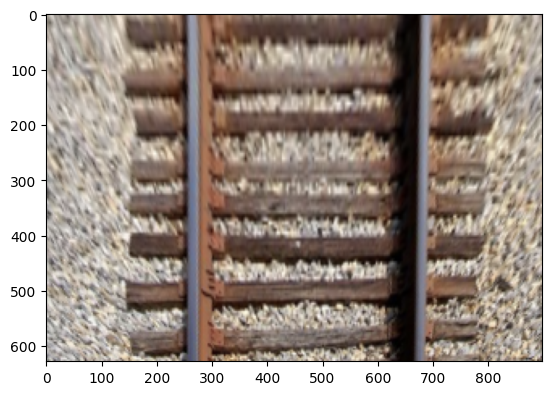

In [8]:
img = cv2.imread("../data/tracks2.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

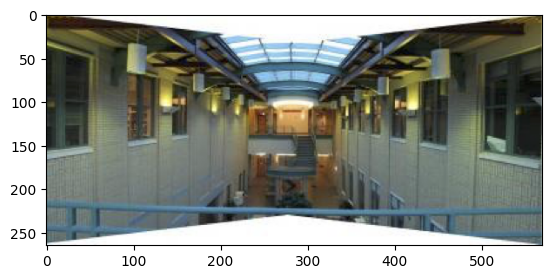

In [9]:
img = cv2.imread("../data/atrium3.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

**Implication**: we need a new, more general class of geometric transformations.

    Wilson: don't mess with the third row!
    Students: what if we mess with the third row?
    Wilson: Well, okay. You asked. Online demo.

([link](https://iis.uibk.ac.at/public/piater/courses/demos/homography/homography.xhtml) again)

#### Extra Demo: Viewpoints

Connect tablet to wireless projection. Open camera app. Point at something rectangular (projector screen?). Show how the shape of the rectangle is imaged in various views.

Specific case: pure rotation of camera (don't move the ipad!)

#### More tablet notes: Homography

**Projective Transformation (Homography)** (8 DOF): most general linear transformation in homogeneous coordinates

$$
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = 
\begin{bmatrix} 
h_{11} & h_{12} & h_{13} \\ 
h_{21} & h_{22} & h_{23} \\ 
h_{31} & h_{32} & h_{33} 
\end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
= H \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

Then convert back to Cartesian coordinates: 
$$
\mathbf{p}' = \begin{bmatrix} x'/w' \\ y'/w' \end{bmatrix}
$$

**Properties:**

- **Scale invariance**: $H$ and $\alpha H$ (for any $\alpha \neq 0$) represent the same transformation
  - Therefore only 8 DOF, not 9
- **Preserved**: Line straightness (straight lines map to straight lines)
- **NOT preserved**: Parallelism, angles, lengths, ratios of lengths

---

**Special cases** (subclasses of homographies):

**Translation** (2 DOF): shift only, no rotation or scaling
$$
H_{\text{translation}} = \begin{bmatrix} 
1 & 0 & t_x \\ 
0 & 1 & t_y \\ 
0 & 0 & 1 
\end{bmatrix}
$$

**Euclidean/Rigid** (3 DOF): rotation + translation (preserves distances and angles)
$$
H_{\text{rigid}} = \begin{bmatrix} 
\cos\theta & -\sin\theta & t_x \\ 
\sin\theta & \cos\theta & t_y \\ 
0 & 0 & 1 
\end{bmatrix}
$$

**Similarity** (4 DOF): rotation + uniform scaling + translation (preserves angles and ratios)
$$
H_{\text{similarity}} = \begin{bmatrix} 
s\cos\theta & -s\sin\theta & t_x \\ 
s\sin\theta & s\cos\theta & t_y \\ 
0 & 0 & 1 
\end{bmatrix}
$$

**Affine** (6 DOF): linear transformation + translation (preserves parallelism)
$$
H_{\text{affine}} = \begin{bmatrix} 
a_{11} & a_{12} & t_x \\ 
a_{21} & a_{22} & t_y \\ 
0 & 0 & 1 
\end{bmatrix}
$$

**Projective/Homography** (8 DOF): full generality (preserves only line straightness)
$$
H_{\text{projective}} = \begin{bmatrix} 
h_{11} & h_{12} & h_{13} \\ 
h_{21} & h_{22} & h_{23} \\ 
h_{31} & h_{32} & h_{33} 
\end{bmatrix}
$$

Note: All restricted forms have bottom row $= [0, 0, 1]$ **except** the full projective transformation.

---

**Uses in Computer Vision:**
- Models the mapping between two views of a planar surface
- Models the transformation due to pure camera rotation (no translation)

## Looking forward: Fitting the best model

We know how to model a geometric transformation. How do we **fit** that model given correspondences?

#### Problem Statement

Given a set of (**imperfect**) feature matches, how do I find the *optimal* transformation that relates the two images?


What's optimal? Our definition: minimize the sum of squared residuals:
$$
\min_T \sum_i||(T\mathbf{p}_i - \mathbf{p}_i')||^2
$$

Our optimistic hope: this ends up being linear and can be solved with **linear least squares**.

In other words, we're looking to turn the minimization of the sum of squared residuals:
  $
  \min_T \sum_i||(T\mathbf{p}_i - \mathbf{p}_i')^2||
  $
  
into a minimization of a linear least squares system:
  $
  \min_\mathbf{x} ||A\mathbf{x} - \mathbf{b}||
  $

Solution approach for all three models (translation, affine, projective):
1. Write down the residuals.
2. Massage into $||A\mathbf{x} - \mathbf{b}||$ form.
3. Solve